In [1]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import scipy
import statsmodels
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, r2_score,mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
def GetData(filename):
    return pd.read_csv(filename,header=0,  index_col=0)


In [3]:

#Get exchange rates
data0 = pd.read_csv('euro-daily-hist_1999_2021.csv')
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Period\Unit:              5878 non-null   object 
 1   [Argentine peso ]         5383 non-null   object 
 2   [Australian dollar ]      5878 non-null   object 
 3   [Bulgarian lev ]          5476 non-null   object 
 4   [Brazilian real ]         5610 non-null   object 
 5   [Canadian dollar ]        5878 non-null   object 
 6   [Swiss franc ]            5878 non-null   object 
 7   [Chinese yuan renminbi ]  5610 non-null   object 
 8   [Cypriot pound ]          2346 non-null   object 
 9   [Czech koruna ]           5878 non-null   object 
 10  [Danish krone ]           5878 non-null   object 
 11  [Algerian dinar ]         5383 non-null   object 
 12  [Estonian kroon ]         3130 non-null   object 
 13  [UK pound sterling ]      5878 non-null   object 
 14  [Greek d

In [4]:
data0.head(5)

,Period\Unit:,[Argentine peso ],[Australian dollar ],[Bulgarian lev ],[Brazilian real ],[Canadian dollar ],[Swiss franc ],[Chinese yuan renminbi ],[Cypriot pound ],[Czech koruna ],...,[Russian rouble ],[Swedish krona ],[Singapore dollar ],[Slovenian tolar ],[Slovak koruna ],[Thai baht ],[Turkish lira ],[New Taiwan dollar ],[US dollar ],[South African rand ]
0,2021-09-20,NaN,1.6201,1.9558,6.2495,1.5056,1.0883,7.5726,NaN,25.432,...,86.0700,10.2173,1.5839,NaN,NaN,39.0620,10.1512,NaN,1.1711,17.3301
1,2021-09-17,NaN,1.6111,1.9558,6.2039,1.4913,1.0931,7.6044,NaN,25.296,...,85.4338,10.1553,1.5851,NaN,NaN,39.1450,10.1323,NaN,1.1780,17.1891
2,2021-09-16,NaN,1.6077,1.9558,6.1611,1.4863,1.0886,7.5849,NaN,25.281,...,85.2347,10.1518,1.5805,NaN,NaN,38.9180,9.9663,NaN,1.1763,17.0544
3,2021-09-15,NaN,1.6153,1.9558,6.1979,1.5004,1.0845,7.6069,NaN,25.318,...,85.9738,10.1360,1.5860,NaN,NaN,38.8650,9.9769,NaN,1.1824,16.8973
4,2021-09-14,NaN,1.6114,1.9558,6.1788,1.4951,1.0887,7.6168,NaN,25.389,...,86.1062,10.1453,1.5870,NaN,NaN,38.9270,9.9848,NaN,1.1814,16.8097


In [5]:
data1=data0[['Period\\Unit:','[US dollar ]']]
data1.columns=['Date','rate']
data1.tail(5)

,Date,rate
5873,1999-01-08,1.1659
5874,1999-01-07,1.1632
5875,1999-01-06,1.1743
5876,1999-01-05,1.1790
5877,1999-01-04,1.1789


In [6]:
drop = []
EURO = []
for i, item in enumerate(data1['rate']):
    if item == '-':
        drop += [i]
    else:
        EURO += [float(item)]

data1 = data1.drop(index=drop)
data1['rate'] = EURO
for col in data1.columns:
    print(col)

Date
rate


In [7]:
import os
outname = 'EUR-USD.csv'

outdir = './'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)

data1.to_csv(fullname,index=False)


In [8]:
data = GetData('EUR-USD.csv')
for col in data.columns:
    print(col)
X_train, X_val = data1[:-30], data1[-30:]

print('X_train Shape: ', X_train.shape)
print('X_val Shape: ', X_val.shape)

rate
X_train Shape:  (5786, 2)
X_val Shape:  (30, 2)


In [9]:
data1.tail(5)

,Date,rate
5873,1999-01-08,1.1659
5874,1999-01-07,1.1632
5875,1999-01-06,1.1743
5876,1999-01-05,1.1790
5877,1999-01-04,1.1789


In [10]:
data1.head(10)

,Date,rate
0,2021-09-20,1.1711
1,2021-09-17,1.1780
2,2021-09-16,1.1763
3,2021-09-15,1.1824
4,2021-09-14,1.1814
5,2021-09-13,1.1780
6,2021-09-10,1.1841
7,2021-09-09,1.1838
8,2021-09-08,1.1827
9,2021-09-07,1.1860


In [11]:
predictions = []

arima = sm.tsa.statespace.SARIMAX(X_train.rate,order=(1,0,0),seasonal_order=(0,1,0,7),
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
#get a 30 days prediction
predictions.append(arima.forecast(30))
#converting and reshaping
predictions = np.array(predictions).reshape((30,))

In [12]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              rate   No. Observations:                 5786
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood               18529.397
Date:                           Fri, 24 Dec 2021   AIC                         -37054.794
Time:                                   04:00:15   BIC                         -37041.470
Sample:                                        0   HQIC                        -37050.158
                                          - 5786                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8589      0.005    187.023      0.000       0.850       0.868
sigma2      9.595e-05   1.08e-06     89.248      0.000    9.38e-05    9.81e-05
===================================================================================
Ljung-Box (L1) (Q):                  19.93   Jarque-Bera (JB):              3112.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

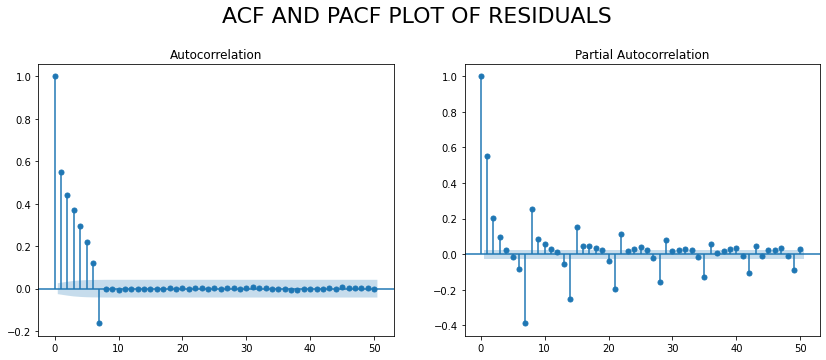

In [13]:
res = arima.resid
fig,ax = plt.subplots(1,2,figsize=(14,5))
plt.suptitle('ACF AND PACF PLOT OF RESIDUALS', fontsize=22, x=0.5, y=1.04)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

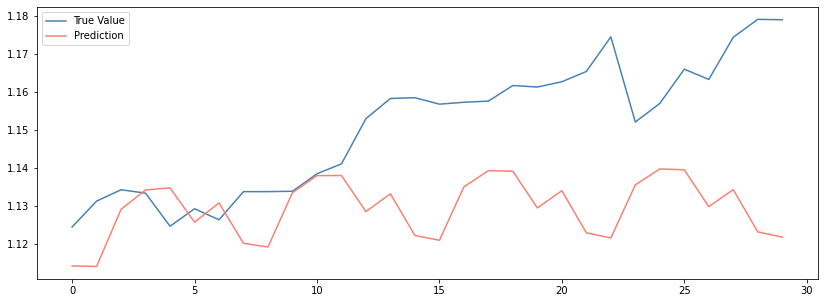

In [14]:
y_val = data1.rate[-30:]
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val)), y_val, color='steelblue');
plt.plot(np.arange(len(y_val)), predictions, color='salmon');
plt.legend(['True Value', 'Prediction']);

In [15]:
arima_mae = mean_absolute_error(y_val, predictions)
arima_mse = mean_squared_error(y_val, predictions)
arima_rmse = np.sqrt(mean_squared_error(y_val, predictions))

print('Mean Absolute Error:   ', arima_mae)
print('Mean Squared Error:   ', arima_mse)
print('Root Mean Squared Error:   ', arima_rmse)

Mean Absolute Error:    0.022355472026667055
Mean Squared Error:    0.0007645587534327545
Root Mean Squared Error:    0.027650655569674193


In [16]:
arima_error_rate = abs(((y_val - predictions) / y_val).mean()) * 100
print('MAPE:', round(arima_error_rate,2), '%')

MAPE: 1.83 %


In [17]:
print('R2-SCORE: ', r2_score(y_val, predictions))

R2-SCORE:  -1.7093992572689194


In [18]:
data1.Date = pd.to_datetime(data1.Date)
data1['day'] = data1.Date.dt.day
data1['dayofweek'] = data1.Date.dt.dayofweek
data1['dayofyear'] = data1.Date.dt.dayofyear
data1['week'] = data1.Date.dt.week
data1['month'] = data1.Date.dt.month
data1['year'] = data1.Date.dt.year

In [19]:
#add lag feature
for i in range(1,8):
    data1['lag'+str(i)] = data1.rate.shift(i).fillna(0)

In [20]:
#drop the date feature
#data.head(10)
#data1.drop(['date'], axis=0, inplace=True)
del data1['Date']
#show new data frame
data1.head(10)
data1.tail()

,rate,day,dayofweek,dayofyear,week,month,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7
5873,1.1659,8,4,8,1,1,1999,1.1569,1.1520,1.1744,1.1653,1.1626,1.1612,1.1616
5874,1.1632,7,3,7,1,1,1999,1.1659,1.1569,1.1520,1.1744,1.1653,1.1626,1.1612
5875,1.1743,6,2,6,1,1,1999,1.1632,1.1659,1.1569,1.1520,1.1744,1.1653,1.1626
5876,1.1790,5,1,5,1,1,1999,1.1743,1.1632,1.1659,1.1569,1.1520,1.1744,1.1653
5877,1.1789,4,0,4,1,1,1999,1.1790,1.1743,1.1632,1.1659,1.1569,1.1520,1.1744


In [21]:
X = data1.drop('rate', axis=1)
y = data1.rate

X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (5786, 13)
y_train:  (5786,)
X_test:  (30, 13)
y_test:  (30,)


In [22]:
X_train

,day,dayofweek,dayofyear,week,month,year,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,20,0,263,38,9,2021,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,17,4,260,37,9,2021,1.1711,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,16,3,259,37,9,2021,1.1780,1.1711,0.0000,0.0000,0.0000,0.0000,0.0000
3,15,2,258,37,9,2021,1.1763,1.1780,1.1711,0.0000,0.0000,0.0000,0.0000
4,14,1,257,37,9,2021,1.1824,1.1763,1.1780,1.1711,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,19,4,50,7,2,1999,1.0992,1.0969,1.1037,1.1031,1.1018,1.0986,1.0887
5844,18,3,49,7,2,1999,1.1163,1.0992,1.0969,1.1037,1.1031,1.1018,1.0986
5845,17,2,48,7,2,1999,1.1232,1.1163,1.0992,1.0969,1.1037,1.1031,1.1018
5846,16,1,47,7,2,1999,1.1253,1.1232,1.1163,1.0992,1.0969,1.1037,1.1031


In [23]:
!pip install bayesian-optimization

You should consider upgrading via the 'C:\Users\User\AppData\Roaming\JetBrains\DataSpell2021.3\projects\workspace\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [24]:
#convert data to xgb matrix form
import xgboost as xgb
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
#convert data to xgb matrix form
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test)

In [25]:
#bayesian hyper parameter tuning
#define the params
def xgb_evaluate(max_depth, gamma, colsample_bytree):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}

    cv_result = xgb.cv(params, dtrain, num_boost_round=250, nfold=3)
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [26]:
#run optimizer
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7),
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
#define iter points
xgb_bo.maximize(init_points=10, n_iter=15, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -0.0281   |  0.594    |  0.9611   |  5.923    |
|  2        | -0.01683  |  0.7312   |  0.2586   |  3.904    |
|  3        | -0.02641  |  0.4077   |  0.8034   |  5.094    |
|  4        | -0.01811  |  0.555    |  0.2989   |  6.695    |
|  5        | -0.01738  |  0.5438   |  0.2602   |  5.412    |
|  6        | -0.01507  |  0.7063   |  0.1827   |  5.4      |
|  7        | -0.01012  |  0.6282   |  0.01229  |  4.815    |
|  8        | -0.02162  |  0.737    |  0.5093   |  4.043    |
|  9        | -0.0257   |  0.8106   |  0.8005   |  3.771    |
|  10       | -0.01799  |  0.6225   |  0.2924   |  6.232    |
|  11       | -0.009017 |  0.827    |  0.001081 |  4.654    |
|  12       | -0.008947 |  0.8781   |  0.004831 |  4.422    |
|  13       | -0.01064  |  0.3728   |  0.002684 |  4.395    |
|  14       | -0.009227 |  0.8065   |  0.003027 |  4.514    |
|  15   

In [27]:
#get the best parameters
params = xgb_bo.max['params']
params['max_depth'] = int(round(params['max_depth']))
#train the data
model = xgb.train(params, dtrain, num_boost_round=200)

In [41]:
#predict the test data
predictions = model.predict(dtest)
predictions

array([1.1190726, 1.1190726, 1.1302528, 1.132766 , 1.132766 , 1.1190726,
       1.1303606, 1.1303208, 1.132834 , 1.132766 , 1.1328738, 1.1347535,
       1.1397048, 1.1548611, 1.1557721, 1.1603582, 1.157616 , 1.1557721,
       1.1557721, 1.1613672, 1.1632111, 1.1632111, 1.1631033, 1.1709092,
       1.1646072, 1.1558799, 1.1630838, 1.1631013, 1.1709071, 1.1784481],
      dtype=float32)

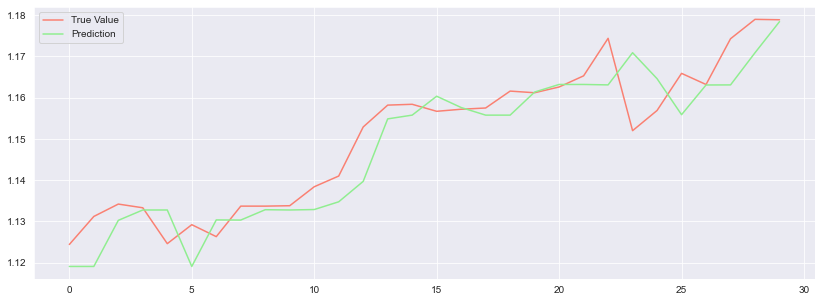

In [29]:
import seaborn as sns
y_val = data.rate[-30:]
plt.figure(figsize=(14,5))
sns.set_style('darkgrid')
plt.plot(np.arange(len(y_val)), y_val, color='salmon');
plt.plot(np.arange(len(y_val)), predictions, color='lightgreen');
plt.legend(['True Value', 'Prediction']);

In [30]:
xgb_mae = mean_absolute_error(y_val, predictions)
xgb_mse = mean_squared_error(y_val, predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_val, predictions))

print('Mean Absolute Error:   ', xgb_mae)
print('Mean Squared Error:   ', xgb_mse)
print('Root Mean Squared Error:   ', xgb_rmse)

Mean Absolute Error:    0.005426470438639316
Mean Squared Error:    5.144635136348506e-05
Root Mean Squared Error:    0.007172611195616633


In [31]:
xgb_error_rate = abs(((y_val - predictions) / y_val).mean()) * 100
print('MAPE:', round(xgb_error_rate,2), '%')

MAPE: 0.22 %


In [32]:
print('R2-SCORE: ', r2_score(y_val, predictions))

R2-SCORE:  0.8176873843277737


In [33]:
#function that can generate a monte carlo simulation
def monte_carlo_simulation(data,t_intervals ,iteration):
    from scipy.stats import norm

    #log returns of data
    log_returns = np.log(1 + data.pct_change())

    #Setting up the drift and random component
    mean_  = log_returns.mean()
    var = log_returns.var()
    stdev = log_returns.std()
    drift = mean_ - (0.5 *var)

    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iteration)))

    S0 = data.iloc[-1]
    #Empty daily returns
    rate_list = np.zeros_like(daily_returns)
    rate_list[0] = S0

    #appliying montecarlo simulation
    for i in range(1 , t_intervals):
        rate_list[i] = rate_list[i-1] * daily_returns[i]

    #Show the result of 30 days simulation
    return rate_list

Text(0, 0.5, 'Value')

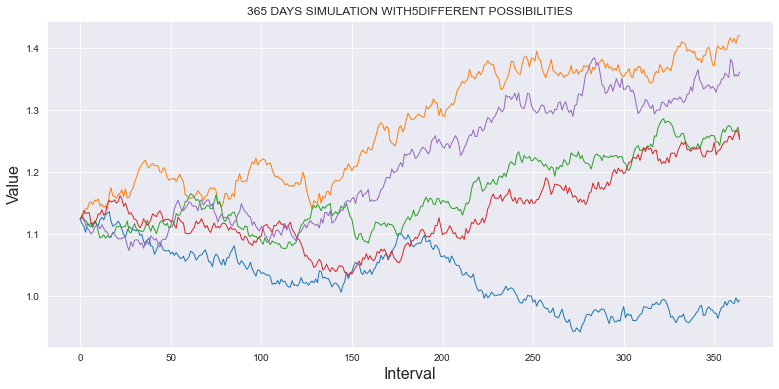

In [34]:
days = 365
diffPos = 5
fig_title =  str(days)+' DAYS SIMULATION WITH'+ str(5) +'DIFFERENT POSSIBILITIES'
similated = monte_carlo_simulation(y_train,days,diffPos)
plt.figure(figsize=(13,6))
plt.plot(similated, lw=1)
plt.title(fig_title)
plt.xlabel('Interval', fontsize=16)
plt.ylabel('Value', fontsize=16)


In [35]:
df = pd.DataFrame(similated)
df

,0,1,2,3,4
0,1.123800,1.123800,1.123800,1.123800,1.123800
1,1.117019,1.130521,1.129766,1.126683,1.125088
2,1.112818,1.133361,1.121348,1.138099,1.126321
3,1.103131,1.140709,1.122429,1.132928,1.114913
4,1.117507,1.140597,1.117295,1.134205,1.109097
...,...,...,...,...,...
360,0.989218,1.409327,1.265773,1.251856,1.376322
361,0.988135,1.415204,1.266435,1.259674,1.354201
362,0.997394,1.407094,1.264452,1.267093,1.357204
363,0.990252,1.418644,1.272361,1.265521,1.354369


In [36]:
from sktime.utils.plotting import plot_series

<Figure size 936x432 with 0 Axes>

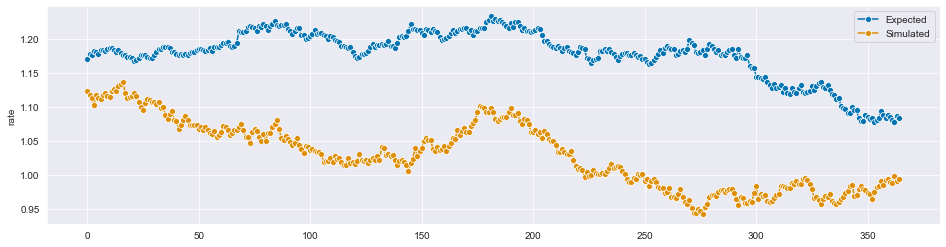

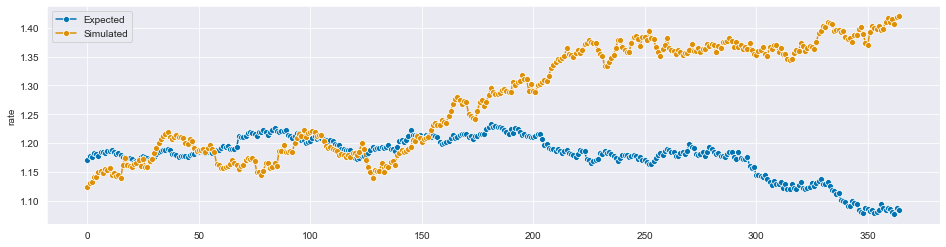

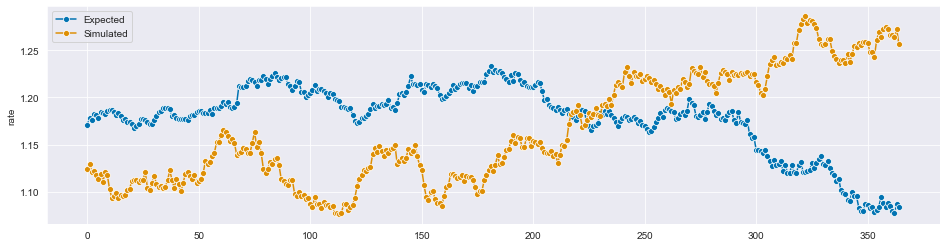

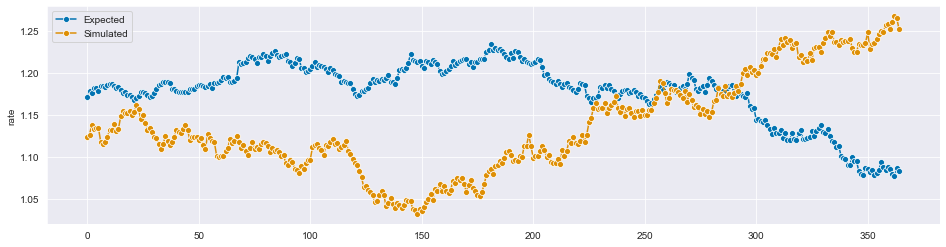

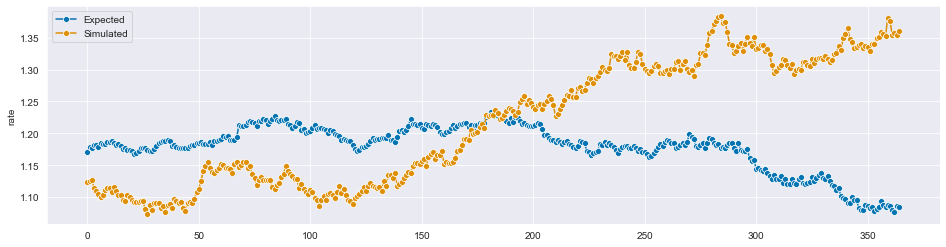

In [37]:
plt.figure(figsize=(13,6))
for i in range(5):
    plot_series(y_train[:365],df[i],labels=['Expected', 'Simulated'])